
# Policy Vulnerability 

After the MORDM analysis has run, the preferred policy has been selected. The python file [used for simulation](./dike_model_simulation.py) has been copied to create experiments from the preferred policy. This has happened in [the best policy dike simulation file](./Bestpolicy_dike_model_simulation.py).

Consequently, these experiments are used for the prim analysis. As described in the report, the PRIM analysis is performed in the end of the analysis cycle to test the vulnerability of the selected policy and create an advice for our client which scenarios to be attentive on and in which scenarios the policy will not create the wished for outcomes. 



In [120]:
#import
from ema_workbench import(
    Model, 
    RealParameter, 
    ScalarOutcome, 
    IntegerParameter, 
    CategoricalParameter)
from ema_workbench.analysis import prim
from dike_model_function import DikeNetwork
from ema_workbench.util import ema_logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from problem_formulation import (
    sum_over,
    get_model_for_problem_formulation,
    )

ema_logging.log_to_stderr(ema_logging.INFO)

# the function get_model_for_problem_formulation is retrieved from the problem_formulation python file
problem_formulation_id = 6
dike_model, planning_steps = get_model_for_problem_formulation(problem_formulation_id=6)


In [116]:
experiments = pd.read_csv('output/experiments_bestpolicy.csv')
outcomes = pd.read_csv('output/outcomes_bestpolicy.csv')

In [117]:
# the outcomes of 'expected annual damage' and 'dike investment costs' are defined as outcomes of interest. 
outcomes_of_interest = ['Expected Annual Damage', 'Dike Investment Costs']
ooi = outcomes_of_interest[0]

PermissionError: [Errno 13] Permission denied: 'img/vulnerability_bestpolicy.png'

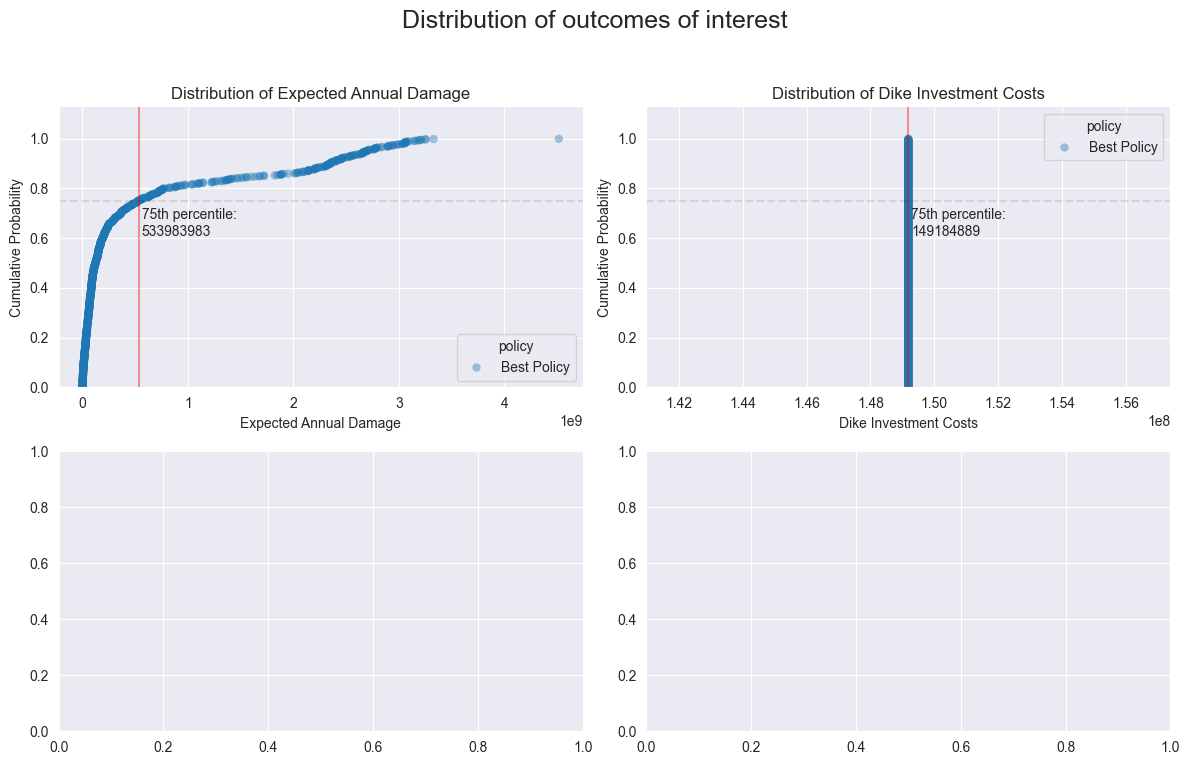

In [125]:
# the 4th quantile of the outcomes of interest are defined 
# the plot shows the vulnerability of the outcomes of interest

N = experiments.shape[0]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for col, ax in zip(outcomes_of_interest, axs.ravel()):
    df = pd.DataFrame()
    df[col] = outcomes[col]
    df['policy'] = experiments['policy']
    df = df.sort_values(by=col, ascending=True)
    df['y'] = np.arange(N) / N
    df = df.reset_index()

    sns.scatterplot(data=df, x=col, y='y', hue='policy',
                    legend=True, linewidth=0,
                    alpha=0.4, palette='tab10', ax=ax)

    q3 = int(N * 0.75)
    ax.axhline(q3 / N, color='k', alpha=0.1, ls='--')
    ax.axvline(df[col][q3], label=str(df[col][q3]),
               color='r', alpha=0.4)

    annotation_point = int(N * 0.61) / N
    if col.split('_')[-1] == 'EAD':
        ax.annotate(text=f"75th percentile:\n{df[col][q3]:.5f}",
                    xy=(df[col][q3], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    else:
        ax.annotate(text=f"75th percentile:\n{df[col][q3]:.0f}",
                    xy=(df[col][q3], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')

    sns.despine(ax=ax)
    col_name = ' '.join(col.split('_'))
    ax.set(xlabel=col_name, ylabel='Cumulative Probability', ylim=[0, 1.125])
    ax.set_title(f'Distribution of {col_name}')

plt.suptitle('Distribution of outcomes of interest', fontsize=18, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig('img/vulnerability_bestpolicy.png')
plt.show()

As the dike investment costs are defined for the preferred policy, the PRIM analysis is begin performed on the outcome variable *Expected Annual Damage*.
The PRIM analysis will test the policy for vulnerability and will in the end results in the 5 worst case scenarios that will be included in the advice for our client.

In [126]:
# the experiments and outcomes from the simulation are read.
data = pd.read_csv('output/experiments_and_outcomes.csv')

# the outcome of interest
outcome_variable = 'Expected Annual Damage'

#defining performance threshold as the 4th quantile of the outcome of interest
performance_threshold = data[outcome_variable].quantile(0.75)

uncertainties = ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2']
# PRIM Analysis
prim_alg = prim.Prim(data, data[outcome_variable] > performance_threshold, threshold=0.75)
box1 = prim_alg.find_box()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 1000 points remaining, containing 250 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.244, coverage: 0.976, density: 1.0 restricted_dimensions: 1


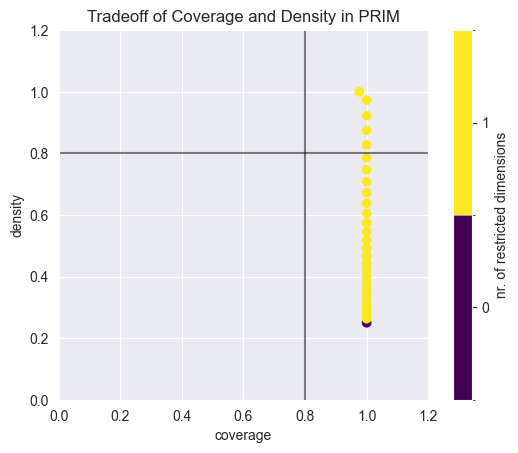

In [127]:
#tradeoffs are plotted
box1.show_tradeoff()

plt.hlines(y=[0.80], xmin=0, xmax=1.2, colors='k', alpha=0.5)
plt.vlines(x=[0.80], ymin=0, ymax=1.2, colors='k', alpha=0.5)
plt.title('Tradeoff of Coverage and Density in PRIM')
plt.savefig('img/vulnerability_prim_trajectory.png')
plt.show()

coverage      1.000000
density       0.922509
id           25.000000
k           250.000000
mass          0.271000
mean          0.922509
n           271.000000
res_dim       1.000000
Name: 25, dtype: float64

                              box 25                                      
                                 min           max       qp value qp value
Expected Annual Damage  4.473649e+08  4.518057e+09  8.169685e-123      NaN


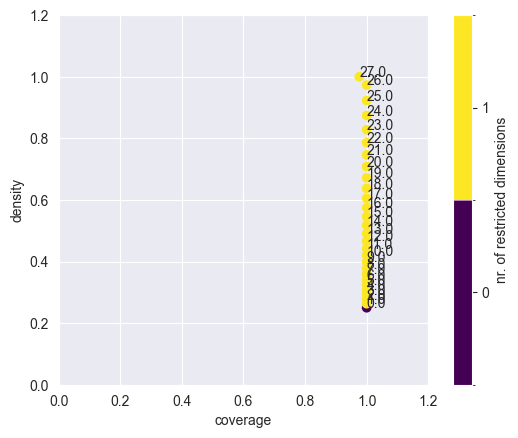

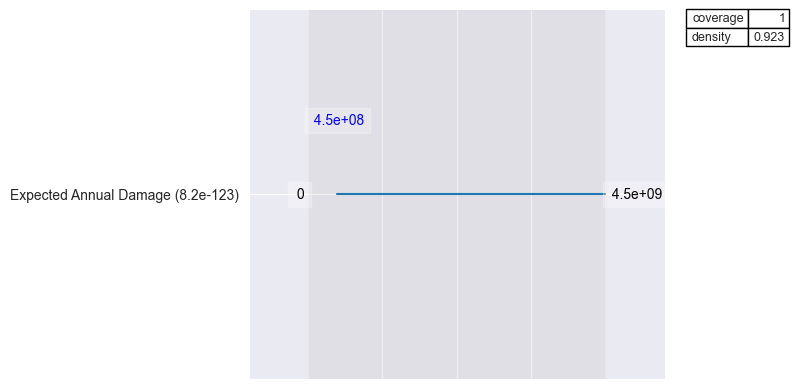

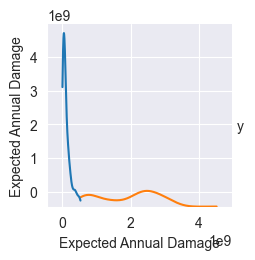

In [128]:
n= 25
box1.show_tradeoff(annotated=True)
box1.inspect(n)
box1.inspect(n, style="graph")
box1.show_pairs_scatter(n)

plt.show()

As the subspace has been defined for the *Expected Annual Damage*, we want to extract the 5 worst case scenarios to give an advice for the client that has a structure for clear communication. 

In [129]:
candidates = box1.peeling_trajectory
candidates = candidates[(candidates.coverage > 0.8)
        & (candidates.density > 0.8)]
print(candidates.head(20))

    coverage   density  id    k   mass      mean    n  res_dim
23     1.000  0.827815  23  250  0.302  0.827815  302        1
24     1.000  0.874126  24  250  0.286  0.874126  286        1
25     1.000  0.922509  25  250  0.271  0.922509  271        1
26     1.000  0.972763  26  250  0.257  0.972763  257        1
27     0.976  1.000000  27  244  0.244  1.000000  244        1


In [130]:
worst_case = candidates[candidates.coverage == candidates.coverage.max()]

worst_case_idx = int(worst_case.index[0])

box1.select(worst_case_idx)
print(worst_case_idx)

23


In [131]:
sns.set_style('whitegrid')

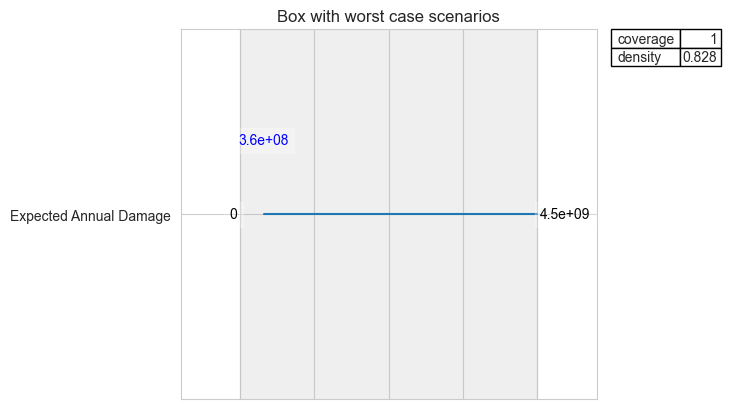

In [132]:
box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')

plt.title('Box with worst case scenarios')
plt.savefig('img/worst_case_bound.png')
plt.show()

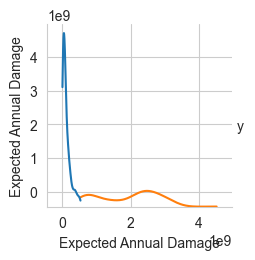

In [133]:
box1.show_pairs_scatter()
plt.savefig('img/worst_case_scatter.png')
plt.show()

In [134]:
limit = box1.box_lims[worst_case_idx]
limit

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs
0,0,30.225003,1.0,0.000156,30.183251,1.0,0.000600,30.062873,1.0,0.000339,...,0,2,0,0,3,0,0,3.607795e+08,1.491849e+08,0
1,132,349.776477,10.0,0.999181,349.721464,10.0,0.999564,349.746576,10.0,0.999399,...,0,2,0,0,3,0,0,4.518057e+09,1.491849e+08,0


In [135]:
combined_df = experiments.copy()
for key in outcomes:
    combined_df[key] = outcomes[key]

combined_df['Within Limit'] = True

print(combined_df.shape)
combined_df.head(5)

(1000, 42)


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Within Limit
0,71,37.451988,10.0,0.912805,259.472333,10.0,0.773299,170.723020,1.5,0.482884,...,3,0,0,0,Best Policy,dikesnet,4.671697e+08,1.491849e+08,0,True
1,39,149.710230,1.5,0.410568,67.805156,10.0,0.623401,74.272836,1.5,0.551172,...,3,0,0,1,Best Policy,dikesnet,6.302566e+06,1.491849e+08,0,True
2,66,51.023776,1.0,0.350786,40.040953,10.0,0.427126,302.011735,10.0,0.168073,...,3,0,0,2,Best Policy,dikesnet,4.144678e+08,1.491849e+08,0,True
3,60,306.010644,10.0,0.149843,263.939873,10.0,0.729386,162.516454,1.0,0.272878,...,3,0,0,3,Best Policy,dikesnet,1.506840e+09,1.491849e+08,0,True
4,9,332.153643,1.5,0.691856,338.321806,1.0,0.585207,295.187559,1.0,0.617270,...,3,0,0,4,Best Policy,dikesnet,1.058516e+08,1.491849e+08,0,True


In [136]:
# the scenarios within the limits are selected
for idx, row in combined_df.iterrows():
    for unc in limit:
        if (type(limit.loc[0, unc]) == set):
            if row[unc] not in limit.loc[0, unc]:
                combined_df.at[idx, 'Within Limit'] = False
        else:
            if row[unc] < limit.loc[0, unc] or row[unc] > limit.loc[1, unc]:
                combined_df.at[idx, 'Within Limit'] = False

In [137]:
combined_df = combined_df[combined_df['Within Limit']]
combined_df = combined_df.drop(['Within Limit'], axis=1)
print(f'{combined_df.shape[0]} scenarios in the PRIM box.')

302 scenarios in the PRIM box.


In [138]:
combined_df = combined_df.sort_values(by=ooi, ascending=False)
combined_df.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs
953,80,339.921175,1.0,0.117154,205.712384,1.0,0.461736,174.276776,1.0,0.004475,...,0,3,0,0,953,Best Policy,dikesnet,4.518057e+09,1.491849e+08,0
697,23,32.568649,1.5,0.114724,132.156924,10.0,0.099387,88.776013,10.0,0.268028,...,0,3,0,0,697,Best Policy,dikesnet,3.330564e+09,1.491849e+08,0
22,68,208.682929,1.0,0.034591,167.161484,10.0,0.223944,228.663985,1.0,0.550157,...,0,3,0,0,22,Best Policy,dikesnet,3.258039e+09,1.491849e+08,0
300,14,241.032773,1.5,0.119962,95.040477,1.0,0.295880,159.050033,1.5,0.751173,...,0,3,0,0,300,Best Policy,dikesnet,3.248843e+09,1.491849e+08,0
578,4,244.260430,10.0,0.107573,283.303036,1.0,0.368108,100.483332,1.5,0.229793,...,0,3,0,0,578,Best Policy,dikesnet,3.210382e+09,1.491849e+08,0


In [139]:
# the 5 worst case scenarios are defined and saved to a csv file for further use.
worst_5 = combined_df.head(5)

worst_5.to_csv('output/worst_5_case_scenarios.csv', index=False)

print(worst_5)

     A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail    A.2_Bmax  \
953                       80  339.921175        1.0   0.117154  205.712384   
697                       23   32.568649        1.5   0.114724  132.156924   
22                        68  208.682929        1.0   0.034591  167.161484   
300                       14  241.032773        1.5   0.119962   95.040477   
578                        4  244.260430       10.0   0.107573  283.303036   

     A.2_Brate  A.2_pfail    A.3_Bmax  A.3_Brate  A.3_pfail  ...  \
953        1.0   0.461736  174.276776        1.0   0.004475  ...   
697       10.0   0.099387   88.776013       10.0   0.268028  ...   
22        10.0   0.223944  228.663985        1.0   0.550157  ...   
300        1.0   0.295880  159.050033        1.5   0.751173  ...   
578        1.0   0.368108  100.483332        1.5   0.229793  ...   

     A.4_DikeIncrease 2  A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
953                   0                   3            